### All code and equations are adapted from the sessions 1.2, 2.1, 2.2 from the CS166 class

# Set up

In [1]:
#Import all the libraries

import numpy as np
import heapq
import matplotlib.pyplot as plt
import scipy.stats as sts
import random




#Code modified from session 2.1 (M/G/1 queue), modified to include manager and more than one queue

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    Attributes
    ----------
    timestamp : float
        The time at which the event should run.
    function : callable
        The function to call when running the event.
    args : tuple
        The positional arguments to pass to the function.
    kwargs : dict
        The keyword arguments to pass to the function.

    Methods
    -------
    __lt__(self, other)
        Compare two events based on their timestamp.
    run(self, schedule)
        Run the event by calling the function with the arguments and keyword


    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        The function to compare two events based on their timestamp.

        Parameters
        ----------
        other
            The other event to compare to.
        
        Returns
        -------
        bool
            True if the timestamp of the current event is less than the timestamp
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        The function to run the event by calling the function with the arguments
        and keyword arguments.
        Parameters
        ----------
        schedule
            The schedule object that contains the event.
            
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    Attributes
    ----------
    now : float
        The time at which the last event was run.
    priority_queue : list
        The priority queue of events.

    Methods
    -------
    add_event_at(self, timestamp, function, *args, **kwargs)
        Add an event to the schedule at a specific time.
    add_event_after(self, interval, function, *args, **kwargs)
        Add an event to the schedule after a specific interval.
    next_event_time(self)
        Return the time at which the next event will run.
    run_next_event(self)
        Run the next event in the schedule.
    __repr__(self)
        Return a string representation of the schedule.
    print_events(self)
        Print the schedule and the events in the queue.


    '''
    
    def __init__(self):
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        The function to add an event to the schedule at a specific time.

        Parameters
        ----------
        timestamp : float
            The time at which the event should run.
        function : callable
            The function to call when running the event.
        args : tuple
            The positional arguments to pass to the function.
        kwargs : dict
            The keyword arguments to pass to the function.
        
        Returns
        -------
        None
        '''
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        The function to add an event to the schedule after a specific interval.

        Parameters
        ----------
        interval : float
            The time after which the event should run.
        function : callable
            The function to call when running the event.
        args : tuple
            The positional arguments to pass to the function.
        kwargs : dict
            The keyword arguments to pass to the function.
        
        Returns
        -------
        None
        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        '''
        The function to return the time at which the next event will run.

        Parameters
        ----------
        None

        Returns
        -------
        float
            The time at which the next event will run.
        '''
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        The function to run the next event in the schedule.

        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        '''
        The function to return a string representation of the schedule.

        Parameters
        ----------
        None

        Returns
        -------
        str
            A string representation of the schedule.
        '''
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        '''
        The function to print the schedule and the events in the queue.

        Parameters
        ----------
        None

        Returns
        -------
        None
        '''
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')
    
    def time(self):
        '''
        The function to return the current time in the format HH:MM.

        Parameters
        ----------
        None

        Returns
        -------
        str
            The current time in the format HH:MM.

        '''
        # Convert time from float to hours and minutes
        hours = int(self.now // 60)
        minutes = int(self.now % 60)
        return f'{str.zfill(str(hours), 2)}:{str.zfill(str(minutes), 2)}'

# Creation of the M/G/1*c simulation

In [66]:

#Add a MGC class to simulate
class Customer:
    '''
    The class to represent a customer in the MGC.

    Attributes
    ----------
    arrival_time : float
        The time at which the customer arrived.
    waiting_time : float
        The time the customer waited in the queue.
    service_time : float
        The time the customer spent in the service.
    '''
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.waiting_time = 0
        self.service_time = 0

class Queue_MGC:
    '''
    The class to represent a  M/G/1 queue.

    Attributes
    ----------
    queue_id : int
        The id of the queue.
    service_distribution : scipy.stats.rv_continuous
        The distribution of the service time.
    manager : Queue_MGC_Manager
        The manager of the queue.
    queue : list
        The queue of customers.
    customers : list
        The list of customers that have been served.
    busy : bool
        Whether the queue is busy.
    max_queue_length : int
        The maximum length of the queue.
    log_events : bool
        Whether to log events.

    Methods
    -------
    __lt__(self, other)
        The function to compare the length of the queue with another queue.
    __len__(self)
        The function to return the length of the queue.
    add_customer(self, schedule, customer)
        The function to add a customer to the queue.
    start_service(self, schedule)
        The function to serve the next customer in the queue.
    end_service(self, schedule, customer)
        The function to end the service of the current customer in that queue.
        
    '''
    def __init__(self, service_distribution, queue_id, manager = None, log_events = True):
        self.queue_id = queue_id
        self.service_distribution = service_distribution
        self.manager = manager
        self.queue = []
        self.customers = []
        self.busy = False
        self.max_queue_length = 0
        self.log_events = log_events
    
    def __lt__(self, other):
        return len(self.queue) + self.busy < len(other.queue) + other.busy

    def __len__(self):
        return len(self.queue)
        
    def add_customer(self, schedule, customer):
        '''
        The function to add a customer to the queue.
        '''
        #add customer to the queue
        self.queue.append(customer)
        self.max_queue_length = max(self.max_queue_length, len(self.queue))
        if self.log_events:
            print(
                f'{schedule.time()}: Add customer to queue {self.queue_id}  '
                f'Queue length: {len(self.queue)}')

        self.customers.append(customer)
        #if the queue is not busy, start serving the customer
        if not self.busy:
            schedule.add_event_after(0, self.start_service)
        
    def start_service(self, schedule):
        '''
        The function to serve the next customer in the queue.'''
        #start serving the customer
        self.busy = True
        customer = self.queue.pop(0)
        customer.waiting_time += schedule.now - customer.arrival_time
        if self.log_events:
            print(
                f'{schedule.time()}: Start serving customer in queue {self.queue_id}  '
                f'Queue length: {len(self.queue)}')
        service_time = self.service_distribution.rvs()
        customer.service_time += service_time
        schedule.add_event_after(service_time, self.end_service, customer)

    def end_service(self, schedule, customer):
        '''
        The function to end the service of the current customer in that queue.
        '''
        #end serving the customer
        self.busy = False
        if self.log_events:
            print(
                f'{schedule.time()}: End serving customer in queue {self.queue_id}  '
                f'Queue length: {len(self.queue)}')
        # Probability of the manager being called
        if self.queue_id != 'Manager' and random.random() < 0.05:
            schedule.add_event_after(0, self.manager.add_customer, customer)
        #if there are more customers in the queue, start serving the next customer
        if len(self.queue) > 0:
            schedule.add_event_after(0, self.start_service)

            
class Manager(Queue_MGC):
    '''
    The class to represent the manager of the M/G/1 queue.
    '''
    def __init__(self, service_distribution, log_events=True):
        super().__init__(service_distribution, queue_id='Manager', log_events=log_events)


#add the manager to teh grocery store class
class GroceryStore_MGC:
    '''
    The class to represent a grocery store with M/G/1 queues.

    Attributes
    ----------
    manager : Queue_MGC_Manager
        The manager of the store.
    queues : list
        The list of queues in the store.
    arrival_distribution : scipy.stats.rv_continuous
        The distribution of the arrival time.
    store_open : int
        The time the store opens.
    store_close : int
        The time the store closes.
    log_events : bool
        Whether to log events.
    
    Methods
    ------- 
    open_store(self, schedule)
        The function to open the store.
    close_store(self, schedule)
        The function to close the store.
    add_customer(self, schedule)
        The function to add a customer to the store.
    run(self, schedule)
        The function to run the simulation.
    '''

    def __init__(self, arrival_distribution, service_distribution, manager_distribution, queue_count, store_open = 540, store_close = 1200, log_events = True):
        self.manager = Manager(manager_distribution, log_events)
        if queue_count > 10:
            raise ValueError('The maximum number of queues is 10')
        if queue_count < 1:
            raise ValueError('The minimum number of queues is 1')
        if store_open < 0:
            raise ValueError('The store cannot open before 0')
        if store_close > 1440:
            raise ValueError('The store cannot close after 1440')
        if store_open > store_close:
            raise ValueError('The opening time must be before the closing time')
            
        self.queues = [Queue_MGC(service_distribution, queue_id=i, manager=self.manager, log_events=log_events) for i in range(queue_count)]
        self.arrival_distribution = arrival_distribution
        self.store_open = store_open
        self.store_close = store_close
        self.log_events = log_events

    def open_store(self, schedule):
        if self.log_events:
            print(f'Store opens at {schedule.time()}')
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def close_store(self, schedule):
        if self.log_events:
            print(f'Store closes at {schedule.time()}')

    def add_customer(self, schedule):
        # Check if the store is still open
        if schedule.now >= self.store_close:
            return

        # Add this customer to the queue
        customer = Customer(arrival_time = schedule.now)

        # Find the shortest queues and pick one at random
        shortest_queues = [queue for queue in self.queues if len(queue) == len(min(self.queues))]
        queue = random.choice(shortest_queues)
        queue.add_customer(schedule, customer)

        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the store opens and closes
        schedule.add_event_after(
            self.store_open,
            self.open_store)
        schedule.add_event_after(
            self.store_close,
            self.close_store)
        
        # Run the simulation
        while schedule.priority_queue:
            schedule.run_next_event()
        

def run_simulation(arrival_distribution, service_distribution, manager_distribution, queue_count, log_events, store_open = 540, store_close = 1200):
    '''
    The function to run the simulation.
    '''
    schedule = Schedule()
    grocery_store = GroceryStore_MGC(arrival_distribution, service_distribution, manager_distribution, queue_count, log_events=log_events, store_open=store_open, store_close=store_close)
    grocery_store.run(schedule)
    return grocery_store, schedule
        




## Test Cases

In [81]:
# Running with 3 queues
arrival_distribution = sts.expon(scale=1)
service_distribution = sts.norm(loc=3, scale=1)
manager_distribution = sts.norm(loc=5, scale=2)
queue_count = 3
grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, log_events=True)
print("Service ended at", schedule.time())
print(f'🧍🏾‍♀️ There are {[len(queue) for queue in grocery_store.queues]} people in the queue')
print(f'🧍🏾‍♀️ There are {len(grocery_store.manager)} people in the manager queue')

Store opens at 09:00
09:00: Add customer to queue 2  Queue length: 1
09:00: Start serving customer in queue 2  Queue length: 0
09:01: Add customer to queue 1  Queue length: 1
09:01: Start serving customer in queue 1  Queue length: 0
09:01: Add customer to queue 0  Queue length: 1
09:01: Start serving customer in queue 0  Queue length: 0
09:01: Add customer to queue 2  Queue length: 1
09:03: End serving customer in queue 0  Queue length: 0
09:04: Add customer to queue 0  Queue length: 1
09:04: Start serving customer in queue 0  Queue length: 0
09:04: End serving customer in queue 2  Queue length: 1
09:04: Start serving customer in queue 2  Queue length: 0
09:04: End serving customer in queue 1  Queue length: 0
09:05: Add customer to queue 2  Queue length: 1
09:06: Add customer to queue 1  Queue length: 1
09:06: Start serving customer in queue 1  Queue length: 0
09:07: Add customer to queue 0  Queue length: 1
09:07: Add customer to queue 1  Queue length: 1
09:08: End serving customer in 

In [82]:
# Running with 4 queues
queue_count = 4
grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, log_events=True)
print("Service ended at", schedule.time())
print(f'🧍🏾‍♀️ There are {[len(queue) for queue in grocery_store.queues]} people in the queues')
print(f'🧍🏾‍♀️ There are {len(grocery_store.manager)} people in the manager queue')

Store opens at 09:00
09:00: Add customer to queue 1  Queue length: 1
09:00: Start serving customer in queue 1  Queue length: 0
09:00: Add customer to queue 2  Queue length: 1
09:00: Start serving customer in queue 2  Queue length: 0
09:01: Add customer to queue 1  Queue length: 1
09:01: Add customer to queue 0  Queue length: 1
09:01: Start serving customer in queue 0  Queue length: 0
09:03: End serving customer in queue 1  Queue length: 1
09:03: Start serving customer in queue 1  Queue length: 0
09:03: Add customer to queue 3  Queue length: 1
09:03: Start serving customer in queue 3  Queue length: 0
09:04: End serving customer in queue 2  Queue length: 0
09:04: Add customer to queue Manager  Queue length: 1
09:04: Start serving customer in queue Manager  Queue length: 0
09:05: End serving customer in queue 1  Queue length: 0
09:06: End serving customer in queue 3  Queue length: 0
09:07: End serving customer in queue 0  Queue length: 0
09:07: Add customer to queue 1  Queue length: 1
09:

In [78]:
# Testing constraints
queue_count = 11
# Testing the maximum number of queues
try:
    grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, log_events=True)
    raise AssertionError('Simulation doesn\'t raise an error when there are more than 10 queues')
except ValueError as e:
    assert str(e) == 'The maximum number of queues is 10'

# Testing the minimum number of queues
queue_count = 4
try:
    grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=0, log_events=True)
    raise AssertionError('Simulation doesn\'t raise an error when there are less than 1 queue')
except ValueError as e:
    assert str(e) == 'The minimum number of queues is 1'

# Testing the store opening time
try:
    grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, store_open=-1, log_events=True)
    raise AssertionError('Simulation doesn\'t raise an error when the store opens before 0')
except ValueError as e:
    assert str(e) == 'The store cannot open before 0'

# Testing the store closing time
try:
    grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, store_close=1441, log_events=True)
    raise AssertionError('Simulation doesn\'t raise an error when the store closes after 1440')
except ValueError as e:
    assert str(e) == 'The store cannot close after 1440'

# Testing opening time is before closing time
try:
    grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, store_open=1441, store_close=1440, log_events=True)
    raise AssertionError('Simulation doesn\'t raise an error when the store opens after it closes')
except ValueError as e:
    assert str(e) == 'The opening time must be before the closing time'

# Test that no customers are added after the store closes
grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=queue_count, log_events=False)
for queue in grocery_store.queues:
    assert queue.customers[-1].arrival_time < grocery_store.store_close




# Plotting of results

In [24]:
from tqdm import tqdm

cashiers = [i for i in range(1, 11)]
# Define parameters for the simulation
trials = 100
lamda = 1 # arrival rate
mu = 3 # service rate
sigma = 1 # standard deviation of service rate
p_manager = 0.05 # probability of a customer going to the manager after service
manager_mu = 5 # manager service rate
manager_sigma = 2 # standard deviation of manager service rate


100%|██████████| 10/10 [00:52<00:00,  5.27s/it]


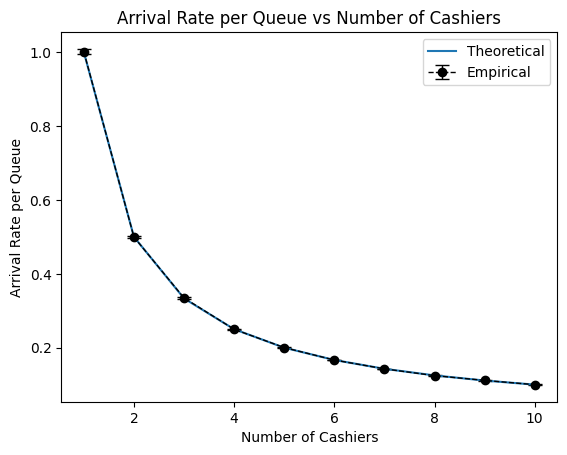

In [51]:
theoretical_lamda_per_queue = []
lamda_per_queue_mean = []
lamda_per_queue_std = []

for cashier_count in tqdm(cashiers):    
    lamda_per_queue = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        lamda_per_queue += [len(queue.customers)/(grocery_store.store_close - grocery_store.store_open) for queue in grocery_store.queues]
    theoretical_lamda_per_queue.append(lamda/cashier_count)
    lamda_per_queue_mean.append(np.mean(lamda_per_queue))
    lamda_per_queue_std.append(1.96*sts.sem(lamda_per_queue))

plt.errorbar(cashiers, lamda_per_queue_mean, yerr=lamda_per_queue_std , marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1, label='Empirical')
plt.plot(cashiers, theoretical_lamda_per_queue, label='Theoretical')
plt.xlabel('Number of Cashiers')
plt.ylabel('Arrival Rate per Queue')
plt.title('Arrival Rate per Queue vs Number of Cashiers')
plt.legend()
plt.show()



#### Average Waiting Time

100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


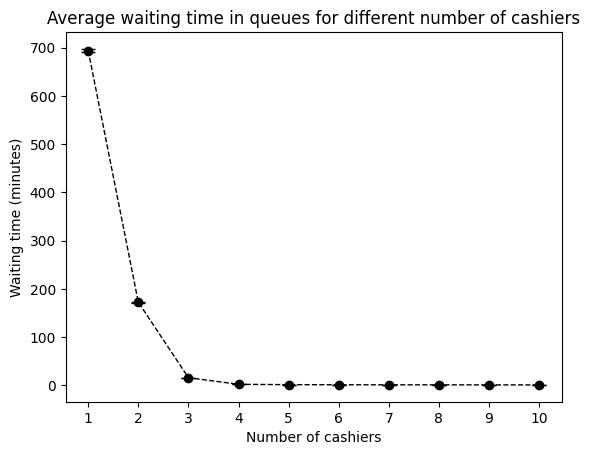

In [25]:
# Run the simulation to comute the average waiting time for each number of queues
waiting_times_mean = []
waiting_times_std = []

for cashier_count in tqdm(cashiers):    
    waiting_times = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        for queue in grocery_store.queues:
            waiting_times = waiting_times + [customer.waiting_time for customer in queue.customers]
    waiting_times_mean.append(np.mean(waiting_times))
    waiting_times_std.append(1.96*sts.sem(waiting_times))

plt.errorbar(cashiers, waiting_times_mean, waiting_times_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Waiting time (minutes)')
plt.title('Average waiting time in queues for different number of cashiers')
plt.show()
    





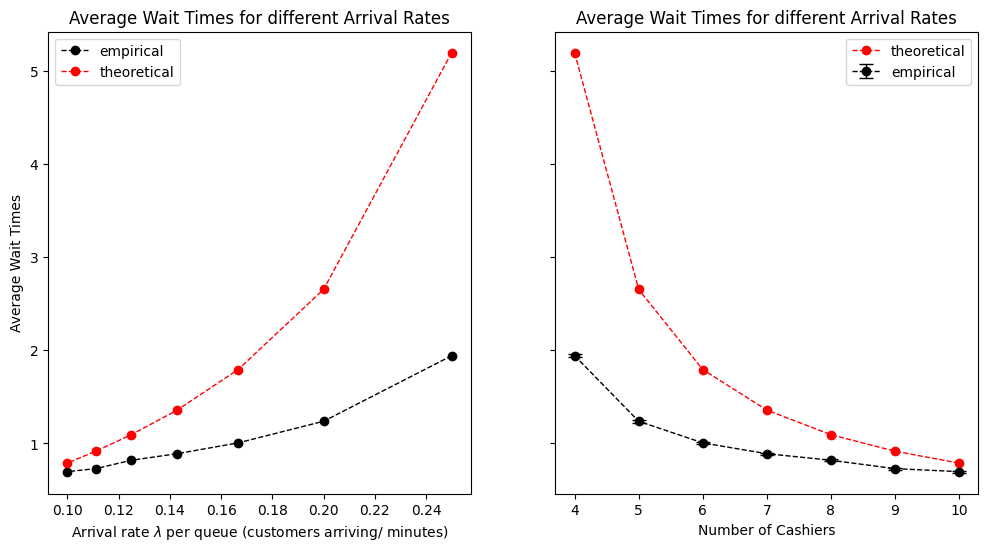

In [56]:
def theoretical_avg_wait_time(lamda, tau=3, sigma=1, manager_tau=5, manager_sigma=2): 
    '''
    This function computes the theoretical average waiting time for a single queue with a given arrival rate, service time and standard deviation of service time.

    Parameters
    ----------
    lamda : float
        The arrival rate of the queue.
    tau : float
        The mean service time of the queue.
    sigma : float
        The standard deviation of the service time of the queue.

    Returns 
    -------
    float
        The theoretical average waiting time for the queue.
    '''
    
    rho = lamda * tau 

    # compute the arrival rate of the manager queue as the arrival/departure rate to the whole system times the probability of a customer going to the manager
    manager_lamda = lamda * p_manager 
    manager_rho = manager_lamda * manager_tau

    # compute the average waiting time for the manager queue
    manager_avg_wait_time = (manager_rho*manager_tau / (2*(1-manager_rho))) * (1 + manager_sigma**2 / manager_tau**2)

    # compute the average waiting time for the system as a whole
    return (rho*tau / (2*(1-rho))) * (1 + (sigma /tau)**2) + manager_avg_wait_time

theoretical_wait_times = []
x_arrival_rate = []
for i in cashiers[3:]: 
    lamda = 1/i # The arrival rate to each queue is inversely proportional to the number of queues
    x_arrival_rate.append(lamda)
    theoretical_wait_times.append(theoretical_avg_wait_time(lamda))

fig, ax = plt.subplots(1, 2, sharey = True, figsize=(12, 6))

ax[0].set_title('Average Wait Times for different Arrival Rates')
ax[0].set_xlabel('Arrival rate $\lambda$ per queue (customers arriving/ minutes)')
ax[0].set_ylabel('Average Wait Times')


ax[0].plot(x_arrival_rate, waiting_times_mean[3:], color='black', marker='o', linestyle='--', linewidth=1, label='empirical')
ax[0].plot(x_arrival_rate, theoretical_wait_times, color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
ax[0].legend()

ax[1].set_title('Average Wait Times for different number of cashiers')
ax[1].set_xlabel('Number of Cashiers')


ax[1].errorbar(cashiers[3:], waiting_times_mean[3:], waiting_times_std[3:], color='black', marker='o', capsize=5, linestyle='--', 
             linewidth=1, label='empirical')
ax[1].plot(cashiers[3:], theoretical_wait_times, color='red', marker='o', linestyle='--', linewidth=1, label='theoretical')
ax[1].legend()
plt.show()

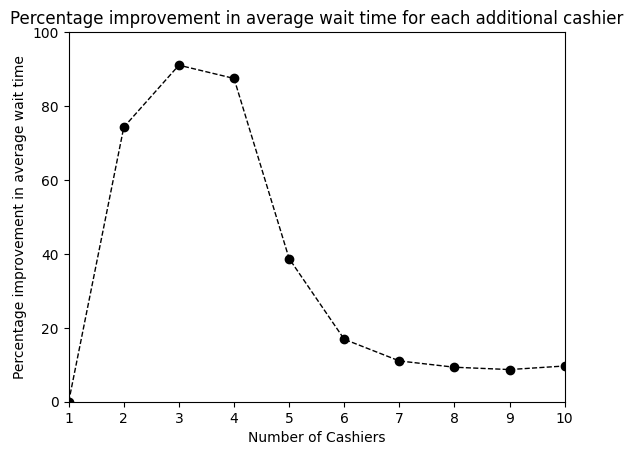

In [17]:
# Plot the percentage improvement in average wait time for each additional cashier
plt.figure()
plt.title('Percentage improvement in average wait time for each additional cashier')
plt.xlabel('Number of Cashiers')
plt.ylabel('Percentage improvement in average wait time')
plt.plot(cashiers, [0] + [100*(waiting_times_mean[i-1] - waiting_times_mean[i])/waiting_times_mean[i-1] for i in range(1, len(waiting_times_mean))], color='black', marker='o', linestyle='--', linewidth=1)
plt.xlim(1, 10)
plt.ylim(0,100)
plt.show()


#### Average Response Time

100%|██████████| 10/10 [00:58<00:00,  5.90s/it]


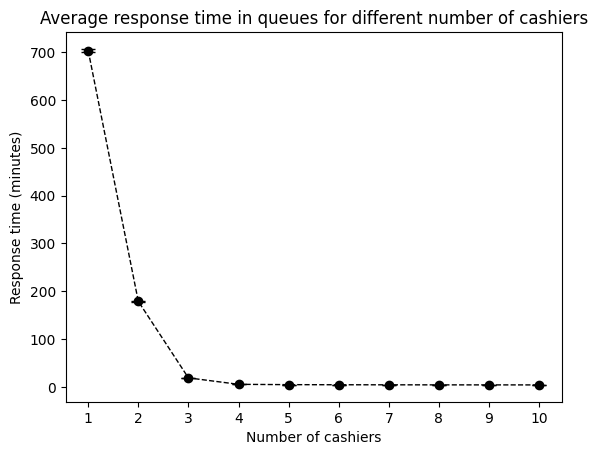

In [57]:
# Average customer response time, defined as the waiting time added by the service time.
# This is the metric we want to minimize.
response_times_mean = []
response_times_std = []

for cashier_count in tqdm(cashiers):
    response_times = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        for queue in grocery_store.queues:
            response_times = response_times + [customer.waiting_time + customer.service_time for customer in queue.customers]
    response_times_mean.append(np.mean(response_times))
    response_times_std.append(1.96*sts.sem(response_times))

plt.errorbar(cashiers, response_times_mean, response_times_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.title('Average response time in queues for different number of cashiers')
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Response time (minutes)')
plt.show()



#### Maximum Queue Length

In [43]:
# Maximum queue length during a day, given the number of cashiers employed.
max_queue_lengths_mean = []
max_queue_lengths_std = []

for cashier_count in tqdm(cashiers):
    max_queue_lengths = []
    for trial in range(trials):
        grocery_store, _ = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        max_queue_lengths.append(max([queue.max_queue_length for queue in grocery_store.queues]))
    max_queue_lengths_mean.append(np.mean(max_queue_lengths))
    max_queue_lengths_std.append(sts.sem(max_queue_lengths))

100%|██████████| 10/10 [00:40<00:00,  4.05s/it]

[440.6, 113.54, 11.43, 3.09, 1.97, 1.21, 1.04, 1.0, 1.0, 1.0]


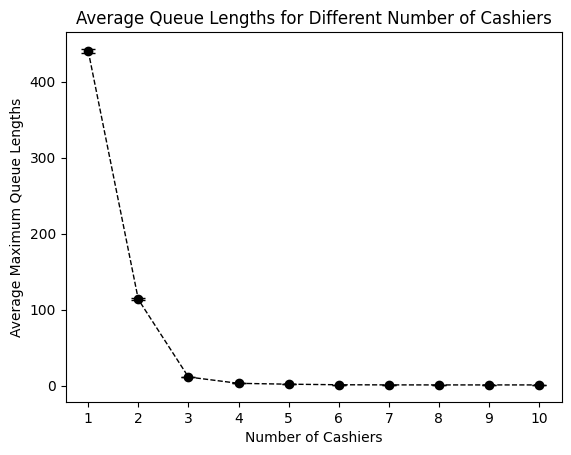

In [58]:
plt.figure()

plt.title('Maximum Queue Lengths for Different Number of Cashiers')
plt.xlabel('Number of Cashiers')
plt.ylabel('Average Maximum Queue Lengths')


plt.errorbar(cashiers, max_queue_lengths_mean, max_queue_lengths_std, color='black', marker='o', capsize=5, linestyle='--', 
             linewidth=1)
plt.xticks(cashiers)
plt.show()

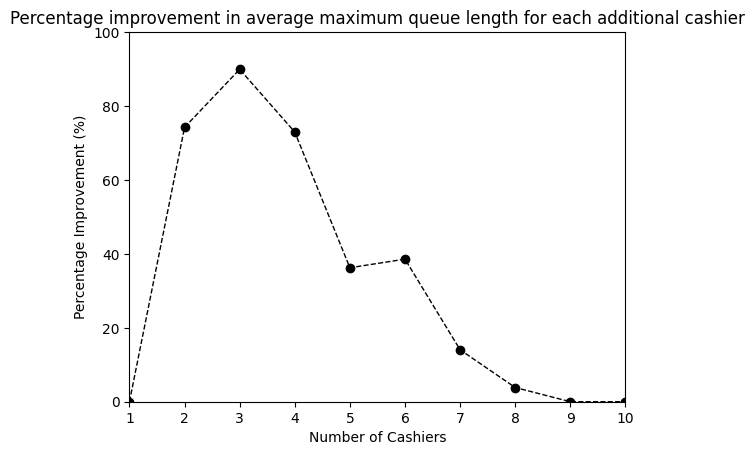

In [74]:
# Plot the percentage improvement in average maximum queue length for each additional cashier
plt.figure()
plt.title('Percentage improvement in average maximum queue length for each additional cashier')
plt.xlabel('Number of Cashiers')
plt.ylabel('Percentage Improvement (%)')
plt.plot(cashiers, [0] + [100*(max_queue_lengths_mean[i-1] - max_queue_lengths_mean[i])/max_queue_lengths_mean[i-1] for i in range(1, len(max_queue_lengths_mean))], color='black', marker='o', linestyle='--', linewidth=1)
plt.xlim(1, 10)
plt.ylim(0,100)
plt.show()

#### Average Post-Closing Completion Time

In [46]:
# Average time after the store closes till the last customer leaves.
# This is the metric we want to minimize.
last_customer_times_mean = []
last_customer_times_std = []

for cashier_count in tqdm(cashiers):
    last_customer_times = []
    for trial in range(trials):
        grocery_store, schedule = run_simulation(arrival_distribution=arrival_distribution, service_distribution=service_distribution, manager_distribution=manager_distribution, queue_count=cashier_count, log_events=False)
        last_customer_times.append(schedule.now - grocery_store.store_close)
    last_customer_times_mean.append(np.mean(last_customer_times))
    last_customer_times_std.append(sts.sem(last_customer_times))

plt.errorbar(cashiers, last_customer_times_mean, last_customer_times_std, marker='o', color = 'black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel('Number of cashiers')
plt.xticks(cashiers)
plt.ylabel('Time (minutes)')
plt.title('Time to attend to remaining customers after closing for different number of cashiers')
plt.show()

 10%|█         | 1/10 [00:03<00:32,  3.65s/it]

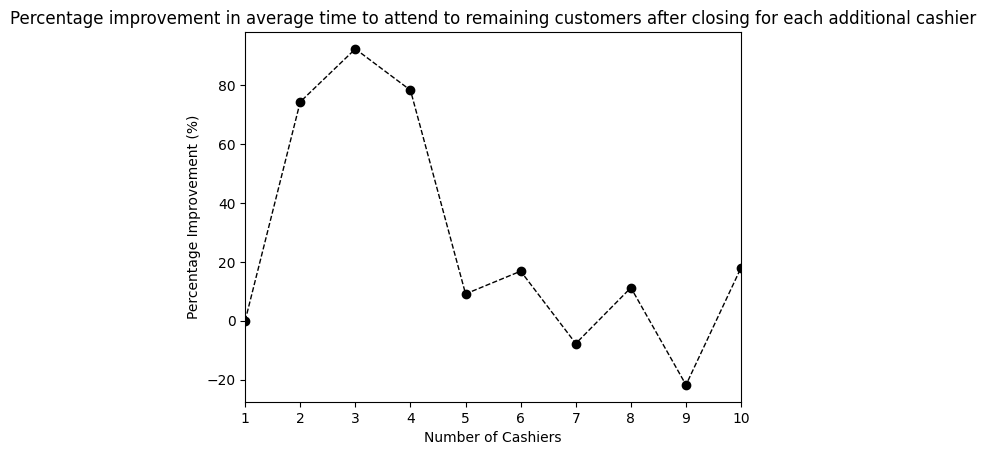

In [83]:
# Plot the percentage improvement in average time to attend to remaining customers after closing for each additional cashier
plt.figure()
plt.title('Percentage improvement in average time to attend to remaining customers after closing for each additional cashier')
plt.xlabel('Number of Cashiers')
plt.ylabel('Percentage Improvement (%)')
plt.plot(cashiers, [0] + [100*(last_customer_times_mean[i-1] - last_customer_times_mean[i])/last_customer_times_mean[i-1] for i in range(1, len(last_customer_times_mean))], color='black', marker='o', linestyle='--', linewidth=1)
plt.xlim(1, 10)
plt.show()


#### M/M/1 Comparison

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


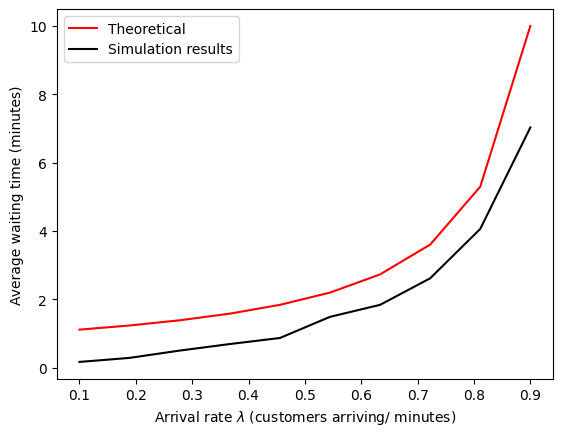

In [107]:
# Try with an M/M/1 queue (because we are using a general equation the results should be teh same if we cahnge the distribution)
def comparison_wait_time():

    val_la = np.linspace(0.1, 0.9, 10)
    theoretical = []
    empirical = []

    for l in tqdm(val_la):
        waiting_times = []
        for trial in range(30):
            grocery_store, _ = run_simulation(arrival_distribution= sts.expon(scale=1/l), service_distribution= sts.expon(scale=1), manager_distribution=manager_distribution, queue_count=1, log_events=False)
            for queue in grocery_store.queues:
                waiting_times = waiting_times + [customer.waiting_time for customer in queue.customers]
        empirical.append(np.mean(waiting_times))
        theoretical.append(1 + l/(1-l))

    plt.plot(val_la, theoretical, color = 'red', label = r'Theoretical')
    plt.plot(val_la, empirical, color = 'black', label = r'Simulation results')
    plt.xlabel(r'Arrival rate $\lambda$ (customers arriving/ minutes)')
    plt.ylabel(r'Average waiting time (minutes)')
    plt.legend()
    plt.show()

comparison_wait_time()